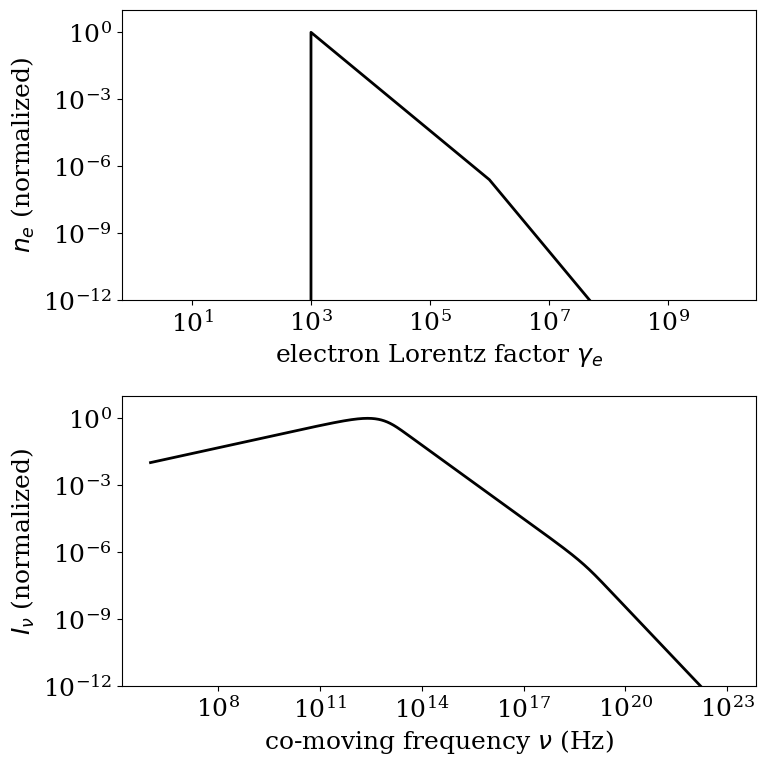

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fnt
""""CODE BY HENDRIK VAN EERTEN"""
# define some constants of nature
c = 2.99792458e10 # light speed [cm] [s^-1]
m_e = 9.1093897e-28 # electron mass [g]
q = 4.803e-10 # electron charge
k_B = 1.380658e-16 # Boltzmann's constant [erg] [K^-1] 
h = 6.6260755e-27 # Planck's constant [erg] [s]

# physics boundary conditions (results are shown in arbitrary scale anyway, so
# don't really matter)
B = 1 # B field strength [Gauss]
T = 1e14 # some temperature in Kelvin, in case of Maxwellian electron distr.

RES = 1000 # numerical resolution of the binned populations

# a function to compute the synchrortron critical frequency corresponding to an
# electron Lorentz factor gamma_e circling around a magnetic field of strength B
def nu_cr(gamma_e, B):

  sina = 1. # averaging over pitch angles, just set to 1 for simplicity now
  omega_cr = gamma_e * gamma_e * B * 3. * q * sina / (2. * m_e * c)
  return omega_cr / (2. * np.pi)

# a function to return the synchrotron spectrum for a single electron, where
# x = nu / nu_cr, "nu" the frequency of interest and "nu_cr" the critical freq.  
def F_synch(x):
  return np.sqrt(3.) * (3. * x / 2.)**(1./3.) * np.exp(-x)
    # this is a not uncommon and not too inaccurate (few percent) approximation

# a function to provide the index number from array A of the entry with a value 
# closest to "value" 
def nearest_index(A, value):
  DA = np.absolute(A-value)
  return DA.argmin()

#-------------------------------------------------------------------------------
# set up populations of electrons

gamma_e = np.logspace(np.log10(2.), 10, RES) # electron bins by Lorentz factor
n_e = np.zeros(RES) # electron number density for given Lorentz factor

# set up the electrons, option 1 
n_e[nearest_index(gamma_e, 1e4)] = 1.0
n_e[nearest_index(gamma_e, 1e5)] = 0.1
n_e[nearest_index(gamma_e, 1e6)] = 0.01


# set up the electrons, option 2, a power law
n_e[:] = 0 # to ensure nothing retained from option 1
gamma_m = 1e3 # a lower cut-off value for the distribution
p_synch = 2.2 # a slope for the distribution
mask = (gamma_e > gamma_m) #& (gamma_e < gamma_m * 1e3) # selecting bins above the cut-off
n_e[mask] = gamma_e[mask]**(-p_synch)


"""
# option 2b, a Maxwellian distribution with power law tail
gamma_T = k_B * T / (m_e * c**2) # a Lorentz factor corresponding to the peak
print("Maxwellian gamma_T = %e Hz at T = %e K" % (gamma_T, T))

n_e = (gamma_e/gamma_T)**2 * np.exp(-gamma_e / gamma_T) # set up Maxwellian
gamma_pl = gamma_T * 20 # set up the starting point of the power law tail
mask = (gamma_e > gamma_pl) # selecting bins above tail starting point
i_pl = nearest_index(gamma_e, gamma_pl) # retrieve index number turnover
n_e[mask] = n_e[i_pl] * (gamma_e[mask] / gamma_pl)**-p_synch
  # set up a population anchored in the value at the starting point of the tail
"""


# set up the electrons, option 3, cooling break too
gamma_c = 1e6 # cooling break Lorentz factor (should really be determined from  
  # balance between injection of electrons and cooling losses)
mask = (gamma_e > gamma_c) # select bins above cooling turnover point
n_e[mask] = n_e[mask] * (gamma_e[mask] / gamma_c)**(-1) # steepen electron pop.

# normalize the electron distribution
n_e = n_e / np.max(n_e)

#-------------------------------------------------------------------------------# set up the resulting photon emission

nu_gamma = np.logspace(6, 23, RES) # photon bins by frequency
n_gamma = np.zeros(RES) # photon number density / emission coefficient /
  # intensity as function of frequency

for ne, ge in zip(n_e, gamma_e):
  # loop over all the electron bins, and for each bin, set their contribution 
  # to all photon bins at once
  n_gamma += ne * F_synch(nu_gamma / nu_cr(ge, B))

"""
# include absorption, scaled to an absorption break, assuming nu_a < nu_m, nu_c
nu_a = 1e8 # want the break to occur here
S_nu = np.empty(len(n_gamma)) # set up a source function array
alpha_nu = np.ones(len(n_gamma)) * (nu_gamma / nu_a)**-(5./3.)
  # sets up an array of absorption coefficients
S_nu = n_gamma / alpha_nu # source function is emission / absorption coefficient
mask = (nu_gamma < nu_a) # select bins below the absorption break
n_gamma[mask] = S_nu[mask] # below absorption we're seeing the source function
  # which has been scaled such that the absorbed spectrum now nicely connects
  # to the optically thin part
"""

# normalize the photon emission distribution
n_gamma = n_gamma / np.max(n_gamma)

#-------------------------------------------------------------------------------
# everything plotting related

# set up the plot
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 18
fig, ax = plt.subplots(2, 1, figsize = (8, 8))

# plot the electron population
ax[0].loglog(gamma_e, n_e, color = 'black', lw = 2, ls = "-")
ax[0].set_xlabel(r"electron Lorentz factor $\gamma_e$")
ax[0].set_ylabel("$n_e$ (normalized)")
ax[0].set_ylim(1e-12, 10)

# plot the resulting photon population
ax[1].loglog(nu_gamma, n_gamma, color = 'black', lw = 2, ls = "-")
ax[1].set_xlabel(r"co-moving frequency $\nu$ (Hz)")
ax[1].set_ylabel("$I_{\\nu}$ (normalized)")
ax[1].set_ylim(1e-12, 10)
plt.tight_layout()

# show
plt.draw()
plt.show()